<a href="https://colab.research.google.com/github/chinardankhara/nlphuggingface/blob/main/textclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets transformers torch matplotlib

In [ ]:
!pip install --upgrade accelerate

### Get Dataset

In [2]:
from datasets import list_datasets, load_dataset

In [3]:
datasets = list_datasets()
print(f"Number of datasets: {len(datasets)}")
print(f"First 10: {datasets[:10]}")

Number of datasets: 36625
First 10: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [4]:
emotions = load_dataset("emotion")
emotions

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

### Wrangling and analysis

In [5]:
train_ds = emotions['train']
print(train_ds.column_names)
print(train_ds.features)

['text', 'label']
{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [6]:
emotions.set_format('pandas')
df = emotions["train"][:]
df

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
...,...,...
15995,i just had a very brief time in the beanbag an...,0
15996,i am now turning and i feel pathetic that i am...,0
15997,i feel strong and good overall,1
15998,i feel like this was such a rude comment and i...,3


In [7]:
def labelname(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(labelname)

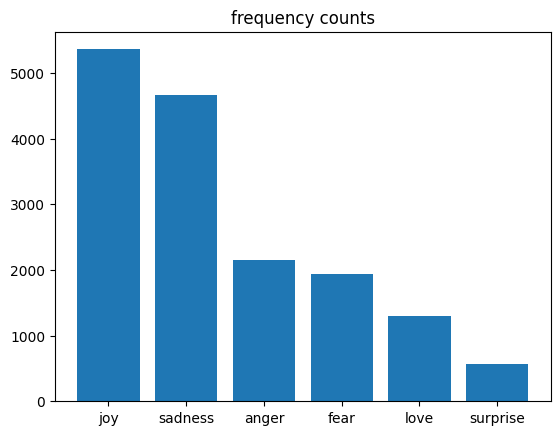

In [8]:
import matplotlib.pyplot as plt

value_counts = df['label_name'].value_counts()

# Create a bar plot
plt.bar(value_counts.index, value_counts.values)
plt.title("frequency counts")
plt.show()

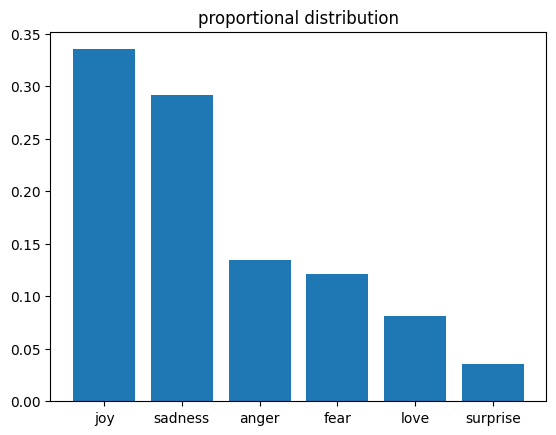

In [9]:
plt.bar(value_counts.index, (value_counts.values/len(df["label_name"])))
plt.title("proportional distribution")
plt.show()

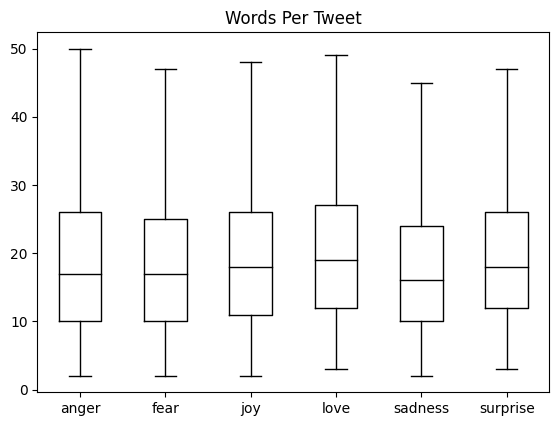

In [10]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False,
          showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

#well under the max context length for distilBERT

In [11]:
emotions.reset_format()

### Character Tokenization

In [12]:
text = emotions["train"][0]["text"]
tokenized_text = list(text)

input_mapping = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}

input_ids = [input_mapping[token] for token in tokenized_text]
input_ids

[6, 0, 2, 6, 2, 9, 10, 0, 4, 3, 3, 7, 0, 5, 11, 8, 6, 7, 6, 1, 10, 3, 2]

In [13]:
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
one_hot = F.one_hot(input_ids, num_classes = len(input_mapping))

### Better Tokenization

In [14]:
from transformers import AutoTokenizer

tokenizer_model = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_model)

In [15]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 1045, 2134, 2102, 2514, 26608, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}


In [16]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(' '.join(i for i in tokens),':::', tokenizer.convert_tokens_to_string(tokens))

[CLS] i didn ##t feel humiliated [SEP] ::: [CLS] i didnt feel humiliated [SEP]


In [17]:
print(tokenizer.vocab_size, tokenizer.model_max_length)
print(tokenizer.model_input_names)

30522 512
['input_ids', 'attention_mask']


In [18]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

emotions = emotions.map(tokenize, batched = True, batch_size = None)


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

### Training Classifier

In [19]:
from transformers import AutoModel
model_checkpoint = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_checkpoint).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
import numpy 

def extract_hidden_states(batch):
    inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()}

In [21]:
emotions.set_format("torch", columns=["input_ids", "attention_mask", "label"])
emotions_hidden = emotions.map(extract_hidden_states, batched = True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [22]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])

In [23]:
from sklearn.linear_model import LogisticRegression

In [25]:
lr_clf = LogisticRegression(max_iter = 5000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.633

In [26]:
from sklearn.dummy import DummyClassifier

In [27]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

In [32]:
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.2205

### Finetuning Approach

In [33]:
from transformers import AutoModelForSequenceClassification
model_checkpoint = "distilbert-base-uncased"
num_labels = 6
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels = num_labels).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.w

In [35]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average = "weighted")
    accuracy = accuracy_score(labels, preds)
    return {"f1": f1, "accuracy": accuracy}

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions["train"]) // batch_size
model_name = f"{model_checkpoint}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error")

In [ ]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

In [45]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [ ]:
emotions.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
emotions["validation"] = emotions["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)
